In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Tensorflow-2.x-Practices/Transfer Learning/

/content/gdrive/My Drive/Tensorflow-2.x-Practices/Transfer Learning


# **Get Cat Dog dataset**

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

# **Load Pretrained model**

In [4]:
path_inception = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                               include_top=False,
                               weights=None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    # Your Code Here
    layer.trainable = False

    
# Print the model summary
# pre_trained_model.summary()

# **Select a layer as last layer in pretrained and add somethings**

In [5]:
from tensorflow.keras.optimizers import RMSprop

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

#Add classifier
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


model = Model(pre_trained_model.input,x)
model.compile(optimizer = RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['acc'])

last layer output shape:  (None, 7, 7, 768)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Load dataset**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import shutil
path_horse_or_human = "train.zip"
path_horse_or_human_valid = "validation.zip"
zip_ref = zipfile.ZipFile(path_horse_or_human, 'r')
zip_ref.extractall('training')
zip_ref_val = zipfile.ZipFile(path_horse_or_human_valid,'r')
zip_ref_val.extractall('validation')

In [10]:
train_dir = "training/train/"
validation_dir = "validation/validation"
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


# **Get Data Augmentation**

In [11]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size=(150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# **Train**

In [12]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
history = model.fit_generator(train_generator,
                             validation_data=validation_generator,
                             steps_per_epoch=20,
                             epochs=3,
                             validation_steps=10,
                             verbose=1,
                             callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
20/20 [==============================] - 26s 341ms/step - loss: 0.4001 - acc: 0.8889 - val_loss: 0.0608 - val_acc: 0.9700
Epoch 2/3
20/20 [==============================] - 6s 300ms/step - loss: 0.0318 - acc: 0.9900 - val_loss: 0.0209 - val_acc: 0.9850

Reached 97.0% accuracy so cancelling training!


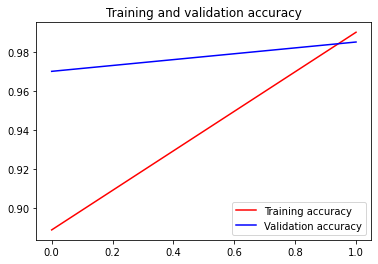

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()